# Life Insurance Application Risk Prediction

A life insurance application takes a long period of time from application to approval, inclusive of the scheduling of medical exams. An extensive amount of information is provided by the customer for the identification of risk classification and eligibility for the insurance applied for. Thus, the lengthy application and approval process discourages people from applying for a life insurance.

The aim is to build a predictive model that will accurately classify the risk of an applicant using an automated approach to help streamline the process. The end result is to predict the "Response" variable for each Id in the test set.

1. [Data Description](#1.-Data-Description)
2. [Importing Packages](#2.-Importing-Packages)
3. [Importing Dataset](#3.-Importing-Dataset)
4. [Data Preprocessing](#4.-Data-Preprocessing)
    - [4.1 Checking for Missing Data](#4.1-Checking-for-Missing-Data)
    - [4.1 Imputing Missing Data](#4.1-Imputing-Missing-Data)
5. [Exploratory Data Analysis (EDA)](#5.-Exploratory-Data-Analysis-(EDA))
6. [Data Manipulation](#6.-Data-Manipulation)
    - 6.1 [Converting categorical variables into dummy/indicator variables](#6.1-Converting-categorical-variables-into-dummy/indicator-variables)
    - 6.2 [Normalising the Data](#6.2-Normalising-the-Data)
7. [Machine Learning Algorithms](#7.-Machine-Learning-Algorithms)
    - [7.1 K-Nearest Neighbors (KNN)](#7.1-K-Nearest-Neighbors-(KNN))
        - [7.1.1 KNN with n_neighbors = 50](#7.1.1-KNN-with-n_neighbors-=-50)
        - [7.1.2 KNN with n_neighbors = 9](#7.1.2-KNN-with-n_neighbors-=-9)
        - [7.1.3 KNN cross-validation](#7.1.3-KNN-cross-validation)
    - [7.2 Logistic Regression](#7.2-Logistic-Regression)
        - [7.2.1 Logistic Regression Cross Validation](#7.2.1-Logistic-Regression-Cross-Validation)
    - [7.3 XGBoost](#7.3-XGBoost)
        - [7.3.1 XGBoost Cross Validation](#7.3.1-XGBoost-Cross-Validation)

## 1. Data Description

The dataset used has 59,381 entries with a total of 128 features including the "Id" and "Response" variables. The data will be split into training, cross validation and testing data.

An additional test will be using the blind_test dataset and the results will be compared with results from other users' submissions on Kaggle.

- data.csv : The dataset set containing the response values.
- blind_test.csv : The test set to be used to predict the response variable for all the rows in the file.
- Id : A unique identifier associated with an application.
- Product_Info_1-7 : A set of normalised variables relating to the product applied for.
- Ins_Age : The normalised age of the applicant.
- Ht : The normalised height of the applicant.
- Wt : The normalised weight of the applicant.
- BMI : The normalised BMI of the applicant.
- Employment_Info_1-6 : A set of normalised variables relating to the employment history of the applicant.
- InsuredInfo_1-7 : A set of normalised variables providing information about the applicant.
- Insurance_History_1-9 : A set of normalised variables relating to the insurance history of the applicant.
- Family_Hist_1-5 : A set of normalised variables relating to the family history of the applicant.
- Medical_History_1-41 : A set of normalised variables relating to the medical history of the applicant.
- Medical_Keyword_1-48 : A set of dummy variables relating to the presence/absence of a medical keyword being associated with the application.
- Response : This is the target variables, an ordinal variable relating to the final decision associated with an application. 

## 2. Importing Packages

In [1]:
# Linear Algebra
import numpy as np

# Data Processing
import pandas as pd
pd.options.display.float_format = '{:.3f}'.format
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_info_columns', 200)

# Imputation
from sklearn.impute import KNNImputer
              
# Data Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Data Normalisation
from sklearn.preprocessing import StandardScaler

# Machine Learning Algorithms
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

## KNN
from sklearn.neighbors import KNeighborsClassifier

## Logistic Regression
from sklearn.linear_model import LogisticRegression

## XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

## 3. Importing Dataset

In [2]:
data = pd.read_csv('./data.csv')
data.shape

(59381, 128)

## 4. Data Preprocessing

### 4.1 Checking for Missing Data

A function is used to check the columns for missing values as well as the percentage of missing values across those columns.

In [4]:
def percentage_missing(df):
    total = df.isnull().sum().sort_values(ascending = False)[df.isnull().sum().sort_values(ascending = False) != 0]
    
    percent = round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2)[round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2) != 0]
    
    return pd.concat([total, percent], axis = 1, keys = ['Total', 'Percentage'])

In [5]:
data_missing = percentage_missing(data)
data_missing

,Total,Percentage
Medical_History_10,58824,99.060
Medical_History_32,58274,98.140
Medical_History_24,55580,93.600
Medical_History_15,44596,75.100
Family_Hist_5,41811,70.410
Family_Hist_3,34241,57.660
Family_Hist_2,28656,48.260
Insurance_History_5,25396,42.770
Family_Hist_4,19184,32.310
Employment_Info_6,10854,18.280


There are nine features with more than 30% of the daa missing. The following were deleted from the dataset:
- Medical_History_10
- Medical_History_32
- Medical_History_24
- Medical_History_15
- Family_Hist_5
- Family_Hist_3
- Family_Hist_2
- Insurance_History_5
- Family_Hist_4

Three of the remaining four categories are continuous and one is discrete. The following three categories are use to classify why that data may be missing:

- Missing Completely at Random (MCAR)
    - Test: [Little's Test using R](http://naniar.njtierney.com/reference/mcar_test.html)

- Missing at Random (MAR)
- Missing Not at Random (MNAR)

R is used to carry out the Little's Test to check if the four features' missing data is Missing Compeltely at Random (MCAR).

![MCARLittlesTest.png](./MCARLittlesTest.png)

Using the Little's Test, three of the variables' p-value is less than 0.05 which  implies that the data is not Missing Completely at Random (MCAR). Thus, it can alternatively be MAR or MNAR.

For the variable "Employment_Info_1" however, the p-value is 1 which gives reason to believe that that feature may be MCAR. As such, the analysis remains unbiased because the missingness of the data does not result in a bias in the estimated parameters.

A list is created to separate the feature names of those to be kept and dropped.

In [7]:
# Creating holding blocks for the lists
droplist = []
imputelist = []

for i in range(len(data_missing)):
    if data_missing["Percentage"][i] > 30:
        droplist.append(data_missing["Percentage"].index[i])
    else:
        imputelist.append(data_missing["Percentage"].index[i])

In [8]:
print(droplist)
print(imputelist)

['Medical_History_10', 'Medical_History_32', 'Medical_History_24', 'Medical_History_15', 'Family_Hist_5', 'Family_Hist_3', 'Family_Hist_2', 'Insurance_History_5', 'Family_Hist_4']
['Employment_Info_6', 'Medical_History_1', 'Employment_Info_4', 'Employment_Info_1']


In [10]:
# Dropping columns with more than 30% of missing data
df = data.drop(labels = droplist, axis = 1)
df.shape

(59381, 119)

In [11]:
# Dropping the 'Id' columns
df.drop(columns = ['Id'], axis = 1, inplace = True)
df.shape

(59381, 118)

### 4.1 Imputing Missing Data

An imputer is applied to the remaining four columns in the data with the missing values.
The fit imputer is applied to the dataset to create a copy of the dataset with values for each column replaced with an estimated value.

In [13]:
# Defining the imputer
imputer = KNNImputer(n_neighbors = 5)

# Fitting the imputer to the four columns and transforming it to a DataFrame
df_filled = pd.DataFrame((imputer.fit_transform(df[imputelist])), columns = imputelist)

In [14]:
# Appending the dataset with the updated missing values
for i in range(len(imputelist)):
    (df[imputelist[i]]) = pd.DataFrame(df_filled[imputelist[i]])

In [16]:
# Checking updated missing value count
percentage_missing(df)

,Total,Percentage


## 5. Exploratory Data Analysis (EDA)

Plots were used to visalise the distribution of features in the dataset.

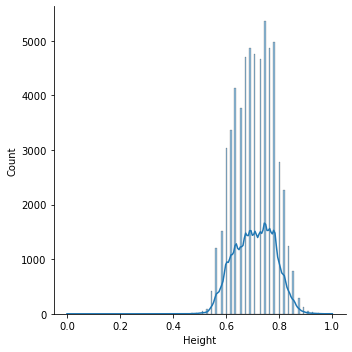

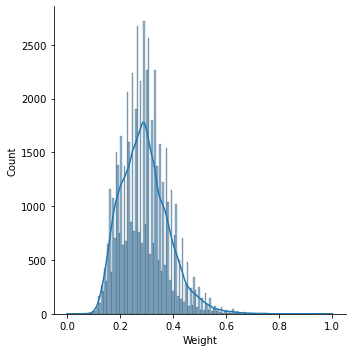

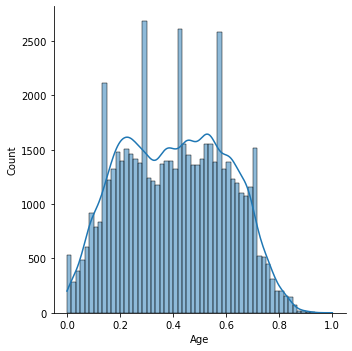

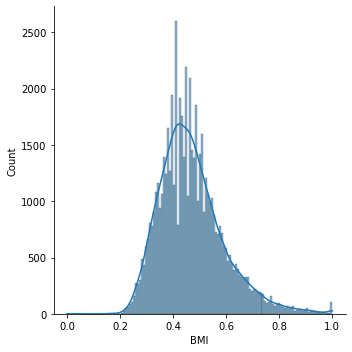

In [17]:
sns.displot(df, x = 'Ht', kde = True).set(xlabel = 'Height')
sns.displot(df, x = 'Wt', kde = True).set(xlabel = 'Weight')
sns.displot(df, x = 'Ins_Age', kde = True).set(xlabel = 'Age')
sns.displot(df, x= 'BMI', kde = True).set(xlabel = 'BMI')

The height can be seen to be skewed to the left and the weight is skewed to the right. The BMI can be seen to be right-skewed though Age has a broad spread in the middle. This is because people around the ages of 20 to 50 are more likely to undertake a life insurance policy.

[Text(0.5, 0, 'Employment_Info_2'), Text(0, 0.5, 'Frequency')]

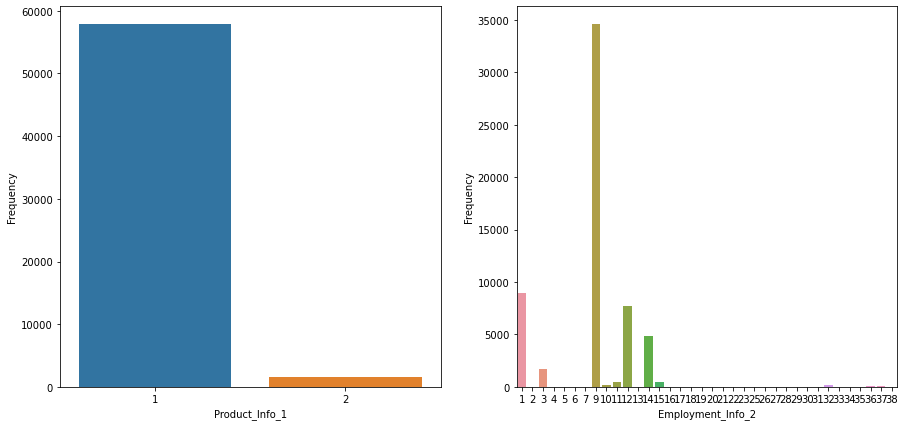

In [18]:
f, axes = plt.subplots(1,2, figsize = (15,7))
sns.countplot(x = 'Product_Info_1', data = df, ax = axes[0]).set(xlabel = 'Product_Info_1', ylabel = 'Frequency')
sns.countplot(x = 'Employment_Info_2', data = df, ax = axes[1]).set(xlabel = 'Employment_Info_2', ylabel = 'Frequency')

Some categorical variables like Product_Info_1 have only two levels whereas Employment_Info_2 has 38 levels. This indicates the potential need for one-hot encoding to transform them for the use of supervised learning algorithms.

[Text(0.5, 0, 'Response'), Text(0, 0.5, 'Frequency')]

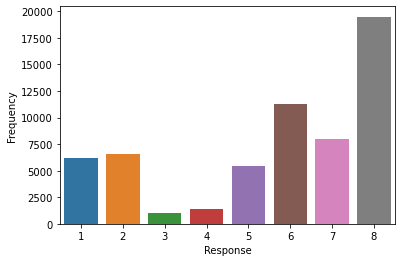

In [19]:
sns.countplot(x = 'Response', data = df).set(xlabel = 'Response', ylabel = 'Frequency')

There is a high percentage of level 8 risk. The range of response variables is unbalanced so an appropriate classification algorithm must be chosen for this situation.

## 6. Data Manipulation

### 6.1 Converting categorical variables into dummy/indicator variables

In [21]:
# Printing original dataset shape post-processing
df.shape

(59381, 118)

In [22]:
df = pd.get_dummies(df)
df.shape

(59381, 136)

The "Response" value is saved separately as the target value in variable "y".

In [23]:
y = df['Response'].reset_index(drop = True)
y.shape

(59381,)

The rest of the columns are saved in variable "X".

In [24]:
X = df
X.drop(columns = ['Response'], axis = 1, inplace = True)
X.shape

(59381, 135)

### 6.2 Normalising the Data

In [26]:
scaler = StandardScaler()

# Fitting the scaler onto the dataset and setting the columns to 
# that of the X dataset
X = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)
X

,Product_Info_1,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,Wt,BMI,Employment_Info_1,Employment_Info_2,Employment_Info_3,Employment_Info_4,Employment_Info_5,Employment_Info_6,InsuredInfo_1,InsuredInfo_2,InsuredInfo_3,InsuredInfo_4,InsuredInfo_5,InsuredInfo_6,InsuredInfo_7,Insurance_History_1,Insurance_History_2,Insurance_History_3,Insurance_History_4,Insurance_History_7,Insurance_History_8,Insurance_History_9,Family_Hist_1,Medical_History_1,Medical_History_2,Medical_History_3,Medical_History_4,Medical_History_5,Medical_History_6,Medical_History_7,Medical_History_8,Medical_History_9,Medical_History_11,Medical_History_12,Medical_History_13,Medical_History_14,Medical_History_16,Medical_History_17,Medical_History_18,Medical_History_19,Medical_History_20,Medical_History_21,Medical_History_22,Medical_History_23,Medical_History_25,Medical_History_26,Medical_History_27,Medical_History_28,Medical_History_29,Medical_History_30,Medical_History_31,Medical_History_33,Medical_History_34,Medical_History_35,Medical_History_36,Medical_History_37,Medical_History_38,Medical_History_39,Medical_History_40,Medical_History_41,Medical_Keyword_1,Medical_Keyword_2,Medical_Keyword_3,Medical_Keyword_4,Medical_Keyword_5,Medical_Keyword_6,Medical_Keyword_7,Medical_Keyword_8,Medical_Keyword_9,Medical_Keyword_10,Medical_Keyword_11,Medical_Keyword_12,Medical_Keyword_13,Medical_Keyword_14,Medical_Keyword_15,Medical_Keyword_16,Medical_Keyword_17,Medical_Keyword_18,Medical_Keyword_19,Medical_Keyword_20,Medical_Keyword_21,Medical_Keyword_22,Medical_Keyword_23,Medical_Keyword_24,Medical_Keyword_25,Medical_Keyword_26,Medical_Keyword_27,Medical_Keyword_28,Medical_Keyword_29,Medical_Keyword_30,Medical_Keyword_31,Medical_Keyword_32,Medical_Keyword_33,Medical_Keyword_34,Medical_Keyword_35,Medical_Keyword_36,Medical_Keyword_37,Medical_Keyword_38,Medical_Keyword_39,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Product_Info_2_A1,Product_Info_2_A2,Product_Info_2_A3,Product_Info_2_A4,Product_Info_2_A5,Product_Info_2_A6,Product_Info_2_A7,Product_Info_2_A8,Product_Info_2_B1,Product_Info_2_B2,Product_Info_2_C1,Product_Info_2_C2,Product_Info_2_C3,Product_Info_2_C4,Product_Info_2_D1,Product_Info_2_D2,Product_Info_2_D3,Product_Info_2_D4,Product_Info_2_E1
0,-0.165,-2.842,-0.892,-0.084,-2.264,-0.149,1.198,-1.690,-1.618,-1.198,-0.602,0.794,-0.421,-0.190,2.448,-0.824,-0.501,-0.086,0.061,0.363,-0.117,1.202,-0.140,-1.634,-0.169,0.862,-1.014,-0.929,-1.388,-0.823,-1.420,-0.323,-0.795,-0.337,-1.377,-0.086,0.241,-0.071,-0.151,-1.829,0.065,-0.245,0.362,0.159,2.260,0.150,-0.237,-0.188,0.123,-0.350,0.137,0.556,-0.480,0.486,0.100,-0.268,0.544,-0.206,0.086,-3.039,0.429,-0.032,-0.435,0.256,-0.070,0.304,0.128,1.456,-0.209,-0.095,-0.228,-0.122,-0.093,-0.113,-0.119,-0.103,-0.082,-0.195,-0.248,-0.101,-0.077,-0.089,-0.485,-0.113,-0.096,-0.087,-0.097,-0.091,-0.122,-0.196,-0.329,-0.139,-0.313,-0.117,-0.110,-0.123,-0.109,-0.160,-0.105,-0.147,-0.153,-0.145,-0.084,-0.103,-0.267,-0.083,-0.118,-0.246,-0.101,-0.218,-0.104,-0.087,-0.118,-0.093,-0.143,-0.240,-0.204,-0.185,-0.129,-0.060,-0.115,-0.191,-0.154,-0.361,-0.030,-0.139,-0.069,-0.052,-0.072,-0.061,-0.352,-0.344,1.774,-0.472,-0.216
1,-0.165,0.312,-0.892,-0.084,0.442,-0.149,-1.754,-1.445,-1.806,-1.613,-0.942,-1.808,2.376,-0.190,-0.408,-1.026,-0.501,-0.086,0.061,0.363,-0.117,1.202,-0.140,0.612,-0.169,0.862,-1.014,-0.929,1.260,-0.823,-1.420,-0.241,0.885,-0.337,-1.377,-0.086,0.241,-0.071,-0.151,-1.829,0.065,-0.245,0.362,0.159,-0.443,0.150,-0.237,-0.188,0.123,-0.350,0.137,0.556,-0.480,0.486,0.100,-0.268,0.544,-0.206,0.086,0.329,-2.331,-0.032,-0.435,0.256,-0.070,0.304,0.128,-0.687,-0.209,-0.095,-0.228,-0.122,-0.093,-0.113,-0.119,-0.103,-0.082,-0.195,-0.248,-0.101,-0.077,-0.089,-0.485,-0.113,-0.096,-0.087,-0.097,-0.091,-0.122,-0.196,-0.329,-0.139,-0.313,-0.117,-0.110,-0.123,-0.109,-0.160,-0.105,-0

## 7. Machine Learning Algorithms

In [28]:
# Splitting the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                        test_size = 0.3, random_state = 0)

### 7.1 K-Nearest Neighbors (KNN)

#### 7.1.1 KNN with n_neighbors = 50

In [29]:
# Defining and fitting the model
knn = KNeighborsClassifier(n_neighbors = 50)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=50)

In [36]:
# Applying the fit model to the testing data anc checking accuracy score
knn_pred = knn.predict(X_test)
print("The accuracy score for the KNN algorithm is {0:.2f}%".format(accuracy_score(y_test, knn_pred)*100))

The accuracy score for the KNN algorithm is 41.64%


Checking for best suited set of parameters:

In [45]:
knn_pipe = Pipeline([('knn', KNeighborsClassifier(n_jobs =- 1))])

In [46]:
knn_params = {'knn__n_neighbors': range(1,10)}

In [50]:
knn_grid = GridSearchCV(knn_pipe, knn_params,
                        cv=5, n_jobs=-1, verbose=True)

In [51]:
knn_grid.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\Ren\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Users\Ren\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan 0.38240402 0.38945309
        nan 0.40227604        nan]
  category=UserWarning


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('knn',
                                        KNeighborsClassifier(n_jobs=-1))]),
             n_jobs=-1, param_grid={'knn__n_neighbors': range(1, 10)},
             verbose=True)

In [52]:
knn_grid.best_params_, knn_grid.best_score_

({'knn__n_neighbors': 8}, 0.4022760418751076)

#### 7.1.2 KNN with n_neighbors = 9

Running the model with n_neighbors set to 9.

In [55]:
knn9 = KNeighborsClassifier(n_neighbors = 9)
knn9.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=9)

In [56]:
knn9_pred = knn9.predict(X_test)
print("The accuracy score for the KNN algorithm with n_neighbor = 9 is {0:.2f}%".format(accuracy_score(y_test, knn9_pred)*100))

The accuracy score for the KNN algorithm with n_neighbor = 9 is 40.12%


#### 7.1.3 KNN cross-validation

In [41]:
knn_scores = cross_val_score(knn, X_train, y_train, cv = 5)
knn_scores

array([0.40293481, 0.41039211, 0.41135434, 0.41640606, 0.4087082 ,
       0.41111378, 0.42276227, 0.41770934, 0.41746872, 0.41337825])

In [42]:
knn9_scores = cross_val_score(knn9, X_train, y_train, cv = 5)
knn9_scores

array([0.39186914, 0.40509983, 0.4087082 , 0.41640606, 0.39884532,
       0.40245369, 0.41674687, 0.40375361, 0.41145332, 0.40880654])

### 7.2 Logistic Regression

In [57]:
# Using Grid Search to find best set of parameters
lr = LogisticRegression(random_state = 0, class_weight = 'balanced', solver = 'newton-cg')
parameters = {'C': (0.0001, 0.001, 0.01, 0.1, 1, 10)}
skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 0)
grid_search = GridSearchCV(lr, parameters, n_jobs = -1, cv = skf)
grid_search = grid_search.fit(X_train, y_train)
grid_search.best_estimator_
print("The best estimator score for the logistic regression model is {0:.2f}%".format(grid_search.best_score_*100))
#0.42835486509645593

The best estimator score for the logistic regression model is 42.84%


In [58]:
# Defining and fitting the model using the best parameters
lr = LogisticRegression(C=0.1, class_weight = 'balanced', penalty='l2',
                       random_state = 0, solver = 'newton-cg', verbose = 0)
lr.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight='balanced', random_state=0,
                   solver='newton-cg')

In [84]:
lr_pred = lr.predict(X_test)

In [86]:
test_score = lr.score(X_test, y_test)
print("The accuracy score for the logistic regression model is {0:.2f}%".format(test_score*100))
#0.43780974835201847

The accuracy score for the logistic regression model is 43.05%


#### 7.2.1 Logistic Regression Cross Validation

In [82]:
lr_scores = cross_val_score(lr, X_train, y_train, cv = 5)
lr_scores

array([0.42229974, 0.4286058 , 0.43281607, 0.42884639, 0.42740286])

### 7.3 XGBoost

In [61]:
# Defining and fitting the model
xgbmod = XGBClassifier()
xgbmod.fit(X_train, y_train)

C:\Users\Ren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:53:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [64]:
xgb_pred = xgbmod.predict(X_test)
print("The accuracy score for the XGBoost model is {0:.2f}%".format(accuracy_score(y_test, xgb_pred)*100))
#0.7041331857768368

The accuracy score for the XGBoost model is 53.99%


#### 7.3.1 XGBoost Cross Validation

In [65]:
xgb_scores = cross_val_score(xgbmod, X_train, y_train, cv = 5)
xgb_scores

C:\Users\Ren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:55:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Ren\anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
C:\Users\Ren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:56:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Ren\anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
C:\Users\Ren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:56:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Ren\anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
C:\Users\Ren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:57:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Ren\anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
C:\Users\Ren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:57:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Ren\anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


array([0.53800818, 0.53783231, 0.53891495, 0.54264405, 0.54432816])

### 8. Evaluation

#### 8.1 KNN

In [94]:
mean_absolute_error(y_test, knn9_pred)

1.7028346898680886

In [97]:
mean_squared_error(y_test, knn9_pred)

7.009710917765927

#### 8.2 Logistic Regression

In [95]:
mean_absolute_error(y_test, lr_pred)

1.581420151557676

In [99]:
mean_squared_error(y_test, lr_pred)

6.13982598933483

#### 8.1 XGBoost

In [96]:
mean_absolute_error(y_test, xgb_pred)

1.2812236879034522

In [100]:
mean_squared_error(y_test, xgb_pred)

5.27022172326691

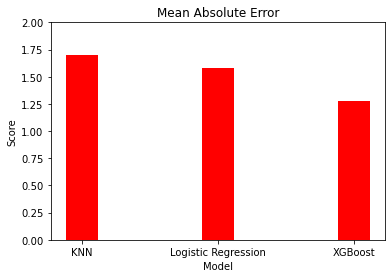

In [114]:
x_lab = ['KNN', 'Logistic Regression', 'XGBoost']
x = np.arange(3)

y = [mean_absolute_error(y_test, knn9_pred), mean_absolute_error(y_test, lr_pred), mean_absolute_error(y_test, xgb_pred)]

fig, ax = plt.subplots()
ax.set_ylim([0,2])
rects1 = ax.bar(x, y, color = "red", align = 'center', width = 0.24)

ax.set_xlabel('Model')
ax.set_ylabel('Score')

ax.set_title('Mean Absolute Error')

plt.xticks(np.arange(3))

ax.set_xticklabels(x_lab)

plt.show()

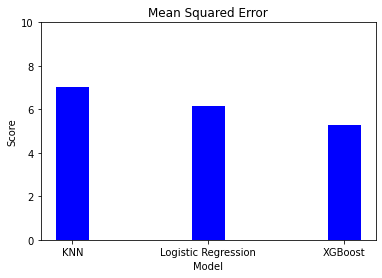

In [115]:
x_lab = ['KNN', 'Logistic Regression', 'XGBoost']
x = np.arange(3)

y = [mean_squared_error(y_test, knn9_pred), mean_squared_error(y_test, lr_pred), mean_squared_error(y_test, xgb_pred)]

fig, ax = plt.subplots()
ax.set_ylim([0,10])
rects1 = ax.bar(x, y, color = "blue", align = 'center', width = 0.24)

ax.set_xlabel('Model')
ax.set_ylabel('Score')

ax.set_title('Mean Squared Error')

plt.xticks(np.arange(3))

ax.set_xticklabels(x_lab)

plt.show()